# Predição de Preços de Casas - (Projeto Kaggle)

Este notebook faz parte de um projeto que desenvolvi para **praticar e aprofundar meus conhecimentos em Machine Learning**.  
Nele, construí um modelo de predição de preços de casas do **Kaggle**, documentando cada etapa do processo: desde a **análise exploratória dos dados (EDA)** e o **tratamento de variáveis**, até as decisões de modelagem.  

Explico o raciocínio por trás de cada escolha, por que iniciei com modelos mais simples, como a **Árvore de Decisão**, como evoluí para o **Random Forest** e, por fim, cheguei ao **XGBoost**, avaliando o desempenho e ajustando o modelo com base nos resultados.


## 1. Preparação inicial e divisão dos dados

Aqui eu carrego os dados, crio a divisão treino/teste que usei durante o desenvolvimento e faço a primeira transformação do target (log1p) — eu optei por log1p para estabilizar a variância dos preços e facilitar o trabalho das perdas baseadas em RMSE / RMSLE.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('train.csv')
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
houses = train_set.drop('SalePrice', axis=1).copy()
houses_labels = train_set['SalePrice'].copy()
houses_labels = np.log1p(houses_labels)

## 2. Análise Exploratória (minha abordagem pessoal)

Ao começar a EDA eu foco em três objetivos práticos: entender o tipo e a quantidade de dados faltantes, identificar quais variáveis têm relação forte com o preço e visualizar distribuições grosseiras que apontem transformações necessárias. Gosto de documentar minhas descobertas como anotações que descrevem decisões futuras (por exemplo, quais features testar em engenharia e o porquê).

Informações básicas do conjunto de treino:
<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 254 to 1126
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    951 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          74 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual 

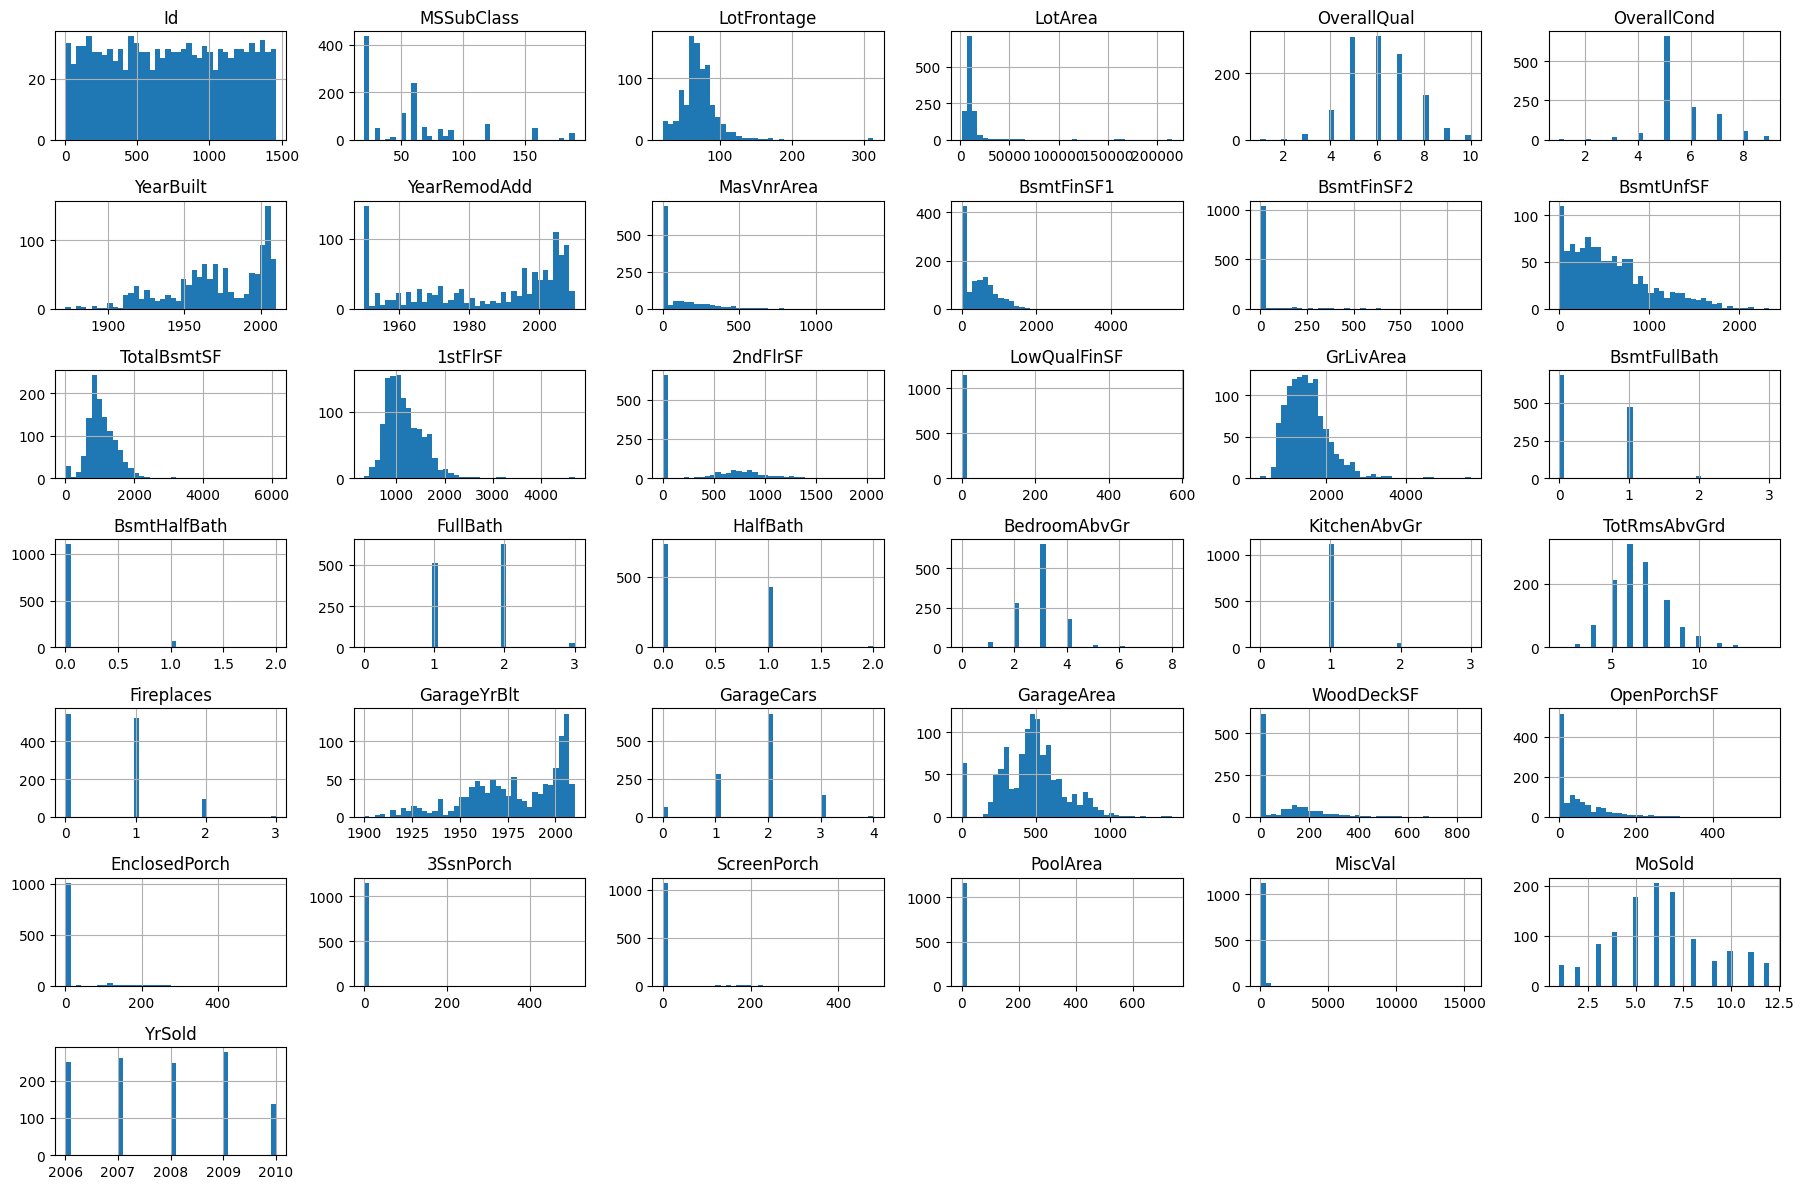

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

print('Informações básicas do conjunto de treino:')
houses.info()
print('\nEstatísticas descritivas das colunas numéricas:')
houses.describe()
houses.select_dtypes(include=['int64','float64']).hist(bins=40, figsize=(18,12))
plt.tight_layout()
plt.show()

### Minhas observações iniciais

- Há várias colunas categóricas e numéricas; alguns campos têm valores ausentes que precisam de estratégia de imputação distinta por tipo.
- Algumas variáveis numéricas apresentam correlações fortes (e potenciais problemas de multicolinearidade).

## 3. Correlação e multicolinearidade

Procuro variáveis com correlação relevante com o target e também pares muito correlacionados entre si. Isso me guia na engenharia de features: se duas variáveis carregam a mesma informação, posso combiná-las ou substituir por uma feature composta.

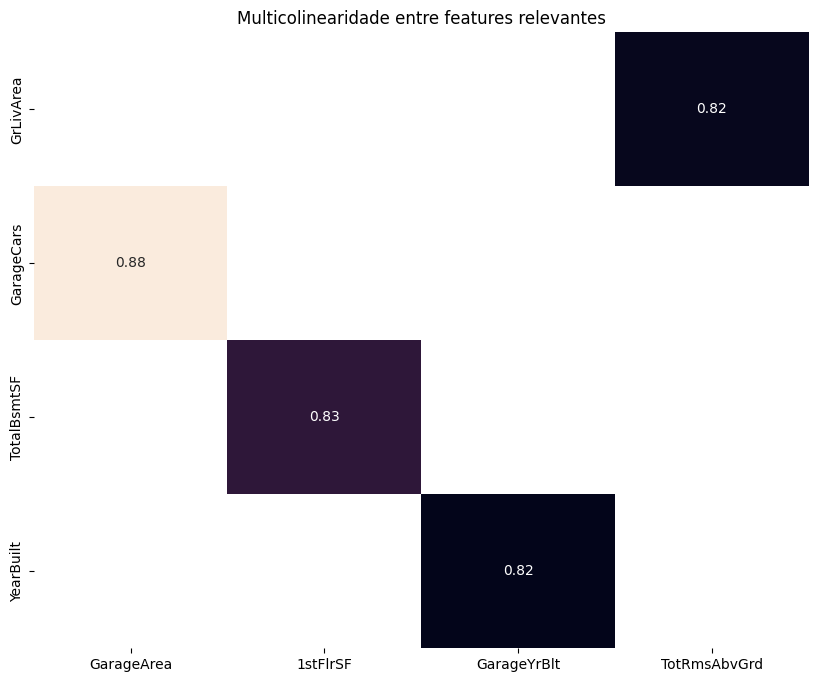

In [3]:
numeric_columns = houses.select_dtypes(include=['int64','float64']).columns
coor_df = pd.concat([houses_labels, houses[numeric_columns]], axis=1)
coor_matrix = coor_df.corr()
corr_with_target = coor_matrix['SalePrice'].sort_values(ascending=False)
corr_with_target.head(20)
LIMITE_RELEVANCIA = 0.3
features_relevantes = corr_with_target[abs(corr_with_target) >= LIMITE_RELEVANCIA].index.tolist()
features_relevantes_sem_alvo = [f for f in features_relevantes if f != 'SalePrice']
matriz_features = houses[features_relevantes_sem_alvo].corr()
mask = np.triu(np.ones(matriz_features.shape), k=1).astype(bool)
matriz_filtrada = matriz_features.where(mask)
matriz_multicolinearidade = matriz_filtrada[abs(matriz_filtrada) > 0.8]
plt.figure(figsize=(10,8))
sns.heatmap(matriz_multicolinearidade.dropna(how='all',axis=0).dropna(how='all',axis=1), annot=True, fmt='.2f', cbar=False)
plt.title('Multicolinearidade entre features relevantes')
plt.show()

## 4. Engenharia de features — como pensei e por que

Depois de olhar para correlações e multicolinearidade, decidi criar duas features compostas que sintetizam informação relevante e reduzem redundância: `TotalSqFt` (soma de área térrea) e `OverallQual_GarageCars` (interação entre qualidade geral e capacidade de garagem). Essas combinações são fruto de observação prática: casas grandes e com boa qualidade + garagem costumam vender mais, e combinar variáveis ajuda modelos simples a capturar isso mais cedo na pipeline.

In [4]:
from sklearn.preprocessing import FunctionTransformer

def add_engineered_features(X):
    X_new = X.copy()
    X_new['TotalSqFt'] = X_new['GrLivArea'].fillna(0) + X_new['TotalBsmtSF'].fillna(0)
    X_new['OverallQual_GarageCars'] = X_new['GarageCars'].fillna(0) * X_new['OverallQual'].fillna(0)
    X_new = X_new.drop(columns=['GrLivArea','TotalBsmtSF','OverallQual','GarageCars'], errors='ignore')
    return X_new

feature_engineer = FunctionTransformer(add_engineered_features, validate=False)
X_engineered = add_engineered_features(houses)
df_corr_test = pd.concat([houses_labels, X_engineered[['OverallQual_GarageCars','TotalSqFt']]], axis=1)
print('Correlação das novas features com SalePrice (log):')
df_corr_test.corr()['SalePrice'].drop('SalePrice')

Correlação das novas features com SalePrice (log):


OverallQual_GarageCars    0.814448
TotalSqFt                 0.758715
Name: SalePrice, dtype: float64

## 5. Pipeline de pré-processamento

A pipeline aplica imputação e escala para numéricos, e imputação + OneHot para categóricos. Mantive `handle_unknown='ignore'` na codificação para evitar problemas no cross-validation quando aparecem categorias novas.

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

temp_df = feature_engineer.transform(houses)
num_attribs = temp_df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_attribs = temp_df.select_dtypes(include=['object']).columns.tolist()
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', sparse_output=False))
preprocessor = ColumnTransformer([('num', num_pipeline, num_attribs), ('cat', cat_pipeline, cat_attribs)], remainder='passthrough')

## 6. Modelos - minha progressão e por quê

Minha intenção era deixar claro no notebook que comecei com modelos simples para ter baseline e entendimento, e só depois parti para modelos mais complexos.

1. Decision Tree como baseline interpretável.
2. Random Forest para melhorar estabilidade e performance.
3. XGBoost como modelo final para extrair ganho adicional.

Em cada passo eu mantenho pipelines que contêm: engenharia de features → pré-processamento → modelo.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

dt_pipeline = Pipeline([
    ('feature_engineer', feature_engineer),
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])
dt_scores = -cross_val_score(dt_pipeline, houses, houses_labels, scoring='neg_root_mean_squared_error', cv=10)
print('Decision Tree RMSE (CV):')
pd.Series(dt_scores).describe()

Decision Tree RMSE (CV):


count    10.000000
mean      0.225267
std       0.032937
min       0.193833
25%       0.199349
50%       0.211458
75%       0.250545
max       0.289277
dtype: float64

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ('feature_engineer', feature_engineer),
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])
rf_scores = -cross_val_score(rf_pipeline, houses, houses_labels, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
print('Random Forest RMSE (CV):')
pd.Series(rf_scores).describe()

Random Forest RMSE (CV):


count    10.000000
mean      0.144767
std       0.031619
min       0.098169
25%       0.121291
50%       0.140692
75%       0.161817
max       0.198794
dtype: float64

### Busca por hiperparâmetros do Random Forest

Aqui eu rodei uma busca aleatória para explorar parâmetros que tivessem impacto prático (n_estimators, max_features, max_depth, min_samples_split). Mantive RandomizedSearchCV para eficiência.

In [8]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'model__n_estimators': randint(low=100, high=800),
    'model__max_features': randint(low=4, high=12),
    'model__max_depth': randint(low=10, high=30),
    'model__min_samples_split': randint(low=2, high=10)
}
rf_search_pipeline = Pipeline([
    ('feature_engineer', feature_engineer),
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])
rnd_search = RandomizedSearchCV(rf_search_pipeline, param_distributions=param_distribs, n_iter=50, cv=10, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
rnd_search.fit(houses, houses_labels)
print('Melhores parâmetros (Random Forest):')
rnd_search.best_params_
print('Melhor RMSE (CV) encontrado:')
-rnd_search.best_score_

Melhores parâmetros (Random Forest):
Melhor RMSE (CV) encontrado:


0.1523411051641704

## 7. XGBoost — por que e como eu usei

Usei XGBoost como etapa final para capturar relações não-lineares mais complexas. A pipeline é a mesma (engenharia + pré-processamento + modelo) para garantir comparabilidade entre os modelos.

In [9]:
import xgboost as xgb
from scipy.stats import uniform

xgb_pipeline = Pipeline([
    ('feature_engineer', feature_engineer),
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(random_state=42, objective='reg:squarederror', enable_categorical=False))
])
param_distribs_xgb = {
    'model__n_estimators': randint(low=100, high=1000),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__max_depth': randint(low=3, high=10),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__reg_lambda': uniform(0.1, 1.0)
}
rnd_search_xgb = RandomizedSearchCV(xgb_pipeline, param_distributions=param_distribs_xgb, n_iter=50, cv=10, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
rnd_search_xgb.fit(houses, houses_labels)
print('Melhores parâmetros (XGBoost):')
rnd_search_xgb.best_params_
print('Melhor RMSE (CV) XGBoost:')
-rnd_search_xgb.best_score_

Melhores parâmetros (XGBoost):
Melhor RMSE (CV) XGBoost:


0.1235362233931199

## 8. Avaliação final no conjunto de teste e importância de features

Para comparar de forma justa, faço a previsão no conjunto de teste original (sem log revertido). Como eu venho usando log1p no target, a métrica RMSLE é calculada como RMSE entre log1p(real) e predição em log. Também exibo as features mais importantes do XGBoost para justificar qualitativamente o que o modelo aprendeu.

In [13]:
from sklearn.metrics import root_mean_squared_error

final_model_xgb = rnd_search_xgb.best_estimator_
X_test_input = test_set.drop('SalePrice', axis=1).copy()
y_test_real = test_set['SalePrice'].copy()
y_test_log = np.log1p(y_test_real)
xgb_pred_log = final_model_xgb.predict(X_test_input)
final_rmsle = root_mean_squared_error(y_test_log, xgb_pred_log)
print(f'RMSLE final (teste): {final_rmsle:.5f}')
feature_names_out = final_model_xgb.named_steps['preprocessor'].get_feature_names_out()
features_importances = final_model_xgb.named_steps['model'].feature_importances_
feature_labels = [name.split('__')[-1] for name in feature_names_out]
importance_series = pd.Series(features_importances, index=feature_labels)
print('\nTop 10 features mais importantes (XGBoost):')
importance_series.sort_values(ascending=False).head(10)

RMSLE final (teste): 0.13077

Top 10 features mais importantes (XGBoost):


OverallQual_GarageCars    0.138537
GarageFinish_Unf          0.091767
TotalSqFt                 0.091224
KitchenQual_TA            0.066260
CentralAir_Y              0.042276
Fireplaces                0.036761
ExterQual_TA              0.035680
GarageType_Detchd         0.033349
MSZoning_RM               0.024056
KitchenAbvGr              0.020203
dtype: float32

## 9. Gerando a submissão para o Kaggle

Aqui eu aplico o modelo final no arquivo `test.csv`, reverto o log1p com expm1 e salvo o CSV de submissão. Anoto também a referência do RMSLE apresentado no projeto (0.12926) como resultado alcançado durante a competição.

In [11]:
entrega_df = pd.read_csv('test.csv')
houses_test_input = entrega_df.copy()
kaggle_pred_log = final_model_xgb.predict(houses_test_input)
kaggle_pred_dolar = np.expm1(kaggle_pred_log)
submission = pd.DataFrame({'Id': entrega_df['Id'], 'SalePrice': kaggle_pred_dolar})
submission.to_csv('submission_final_xgb.csv', index=False)
print('Arquivo submission_final_xgb.csv salvo. Resultado de referência do projeto: RMSLE = 0.12926')

Arquivo submission_final_xgb.csv salvo. Resultado de referência do projeto: RMSLE = 0.12926


## Notas finais (minha reflexão)

- Começar por modelos simples (Decision Tree) foi importante para eu entender limitações e viés em features individuais.
- Random Forest trouxe estabilidade e foi um bom passo intermediário antes de XGBoost.
- A engenharia de features focada em misc features compostas (TotalSqFt, interação OverallQual*GarageCars) simplificou o trabalho e ajudou modelos simples a capturar sinais importantes.
- O RMSLE final de referência (0.12926) foi um marco do projeto e justifica a presença deste trabalho no portfólio.
